In [1]:
%matplotlib notebook
%matplotlib inline

import axs
import numpy as np

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as sparkfunc
import pyspark.sql.types as pyspark_types
import numpy as np

# Setup spark

In [2]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[6]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/users/kyboone/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)


In [3]:
spark_session

Hovering over "Spark UI" above gives you the port number of the Spark web dashboard.  Epyc doesn't have that port open, though, so we use an SSH tunnel to forward the ports.  I like to put the following function into my `.bashrc` o my local machine:


```
function spark_tunnel()
{
        # this function takes one argument: the epyc port to tunnel
        # the ordering is backwards (requiring a manual refresh) because
        # I want to be able to manually kill the ssh tunnel
        open http://localhost:${1}/
        ssh -N -L ${1}:127.0.0.1:${1} username@epyc.astro.washington.edu
}
```

What tables does AXS know about?

# Load ZTF data

In [4]:
ztf = catalog.load('ztf_mar19_all')

# Plotting

In [12]:
def plot_lightcurve(row):
    plt.figure(figsize=(8, 6))

    for filterid in np.unique(row['filterid']):
        cut = (
            (np.array(row['filterid']) == filterid)
            & (np.array(row['catflags']) == 0.)
        )
        def cc(x):
            return np.array(x)[cut]
        plt.errorbar(cc(np.array(row['mjd'])), cc(row['psfmag']), cc(row['psfmagerr']), fmt='o', c='C%d' % filterid, label='Filter %d' % filterid)

    plt.xlabel('mjd')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.title('matchid %d' % row['matchid'])
    plt.gca().invert_yaxis()

# Dipper detection

In [6]:
from scipy.ndimage import minimum_filter1d

def detect_dippers(mjd, filterid, psfmag, psfmagerr, xpos, ypos, catflags, verbose=False, return_mjd=False):
    if len(mjd) == 0:
        return 0.

    order = np.argsort(mjd)

    # Throw out repeated measurements.
    ordered_mjd = np.array(mjd)[order]
    mask = np.abs(ordered_mjd - np.roll(ordered_mjd, 1)) > 1e-5

    mjd = np.array(mjd)[order][mask]
    filterid = np.array(filterid)[order][mask]
    psfmag = np.array(psfmag)[order][mask]
    psfmagerr = np.array(psfmagerr)[order][mask]
    xpos = np.array(xpos)[order][mask]
    ypos = np.array(ypos)[order][mask]
    catflags = np.array(catflags)[order][mask]

    scores = np.zeros(len(psfmag))
    
    pad_width = 20
    x_border = 3072
    y_border = 3080

    for iter_filterid in np.unique(filterid):
        cut = (
            (filterid == iter_filterid)
            & (xpos > pad_width)
            & (xpos < x_border - pad_width)
            & (ypos > pad_width)
            & (ypos < y_border - pad_width)
            & (catflags == 0)
        )

        if np.sum(cut) < 10:
            # Require at least 10 observations to have reasonable statistics.
            continue

        use_psfmag = psfmag[cut]
        use_psfmagerr = psfmagerr[cut]
        
        # Use the middle 60% of observations to estimate the standard deviation
        # of the observations. I empirically calculated a correction factor
        # assuming a normal distribution.
        #core_std = (np.percentile(use_psfmag, 80) - np.percentile(use_psfmag, 20)) / 1.6833
        #print(np.percentile(use_psfmag, 90), np.percentile(use_psfmag, 10))
        #print(np.std(use_psfmag))
        #print(core_std)
        core_std = np.std(use_psfmag)
        filter_scores = (use_psfmag - np.median(use_psfmag)) / np.sqrt(core_std**2 + use_psfmagerr**2)

        scores[cut] = filter_scores
                
    # Check for sequential runs.
    
    # Get the minimum score for a run.
    filtered_scores = minimum_filter1d(scores, 4, mode='constant')
        
    result = float(np.max(filtered_scores))
    max_mjd = mjd[np.argmax(filtered_scores)]

    if verbose:
        print("Max mjd: ", max_mjd)

    if return_mjd:
        return result, max_mjd
    else:
        return result

def detect_dippers_row(row, verbose=False, return_mjd=False):
    return detect_dippers(row['mjd'], row['filterid'], row['psfmag'],
                          row['psfmagerr'], row['xpos'], row['ypos'],
                          row['catflags'],
                          verbose=verbose, return_mjd=return_mjd)

# Create a UDF for spark
detect_dippers_udf = sparkfunc.udf(detect_dippers, returnType=pyspark_types.FloatType())

# Run the spark query

In [7]:
%%time

# Run on spark
res = (
    ztf.region(ra1=290, ra2=292, dec1=25, dec2=27)
    .exclude_duplicates()
    .where(sparkfunc.col("nobs_avail") > 20)
    .select(
        '*',
        detect_dippers_udf(ztf['mjd'], ztf['filterid'], ztf['psfmag'], ztf['psfmagerr'], ztf['xpos'], ztf['ypos'], ztf['catflags']).alias('score')
    )
    .where(sparkfunc.col("score") > 2.)
    .collect()
)
print(len(res))

678
CPU times: user 569 ms, sys: 270 ms, total: 839 ms
Wall time: 20min 47s


# Analysis

In [13]:
# Order the light curves by their scores
scores = []
mjds = []

for i in res:
    score, mjd = detect_dippers_row(i, return_mjd=True)
    scores.append(score)
    mjds.append(mjd)

order = np.argsort(scores)[::-1]

# Apparently things break if you cast a list of spark objects into a numpy array,
# so keep everything as a list.
ordered_res = [res[i] for i in order]

idx: 0
Max mjd:  58522.5619213
5.66212472630605
ra: 291.746366
dec: 26.451333
xpos: 1486.00, ypos: 2387.14
idx: 1
Max mjd:  58219.5098264
4.751037517988468
ra: 291.451201
dec: 25.166837
xpos: 2472.39, ypos: 157.40
idx: 2
Max mjd:  58338.2389931
4.605854554654847
ra: 290.106056
dec: 25.479075
xpos: 160.59, ypos: 2027.91
idx: 3
Max mjd:  58522.5619213
4.512119198075062
ra: 291.533582
dec: 25.402560
xpos: 2197.67, ypos: 2377.93
idx: 4
Max mjd:  58219.5098264
4.459049870733955
ra: 291.730437
dec: 25.065507
xpos: 1579.06, ypos: 522.25


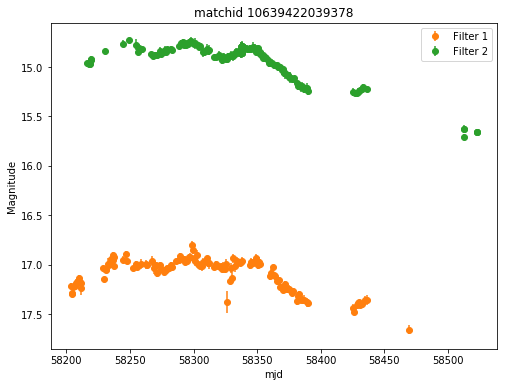

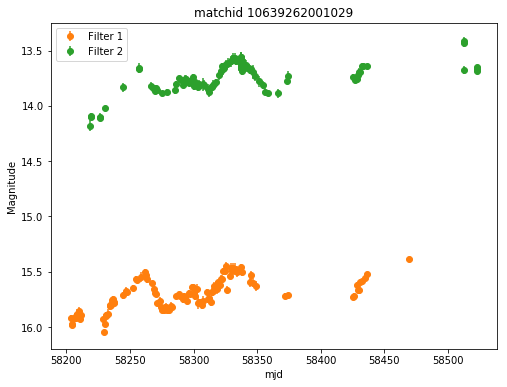

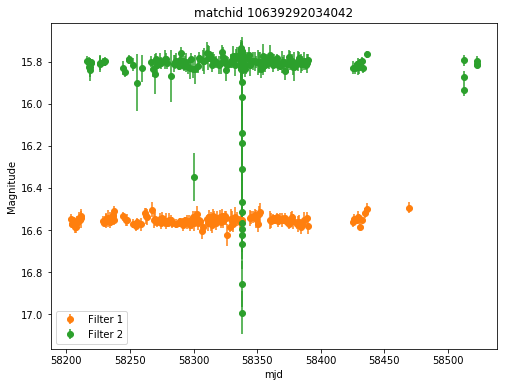

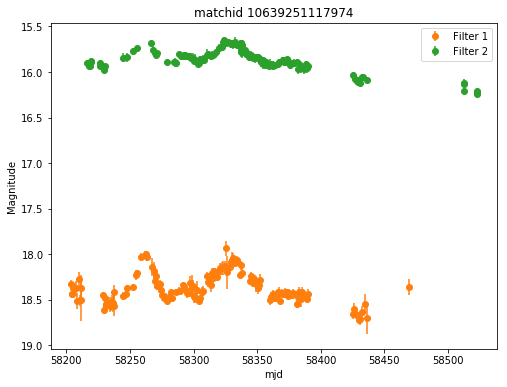

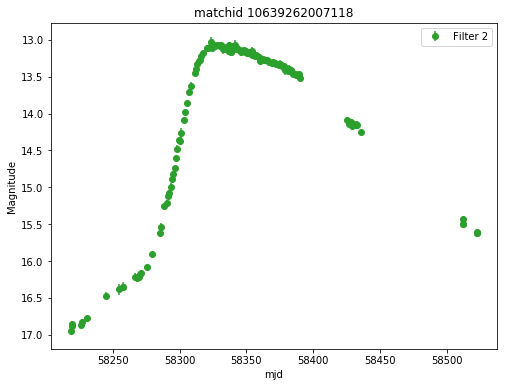

In [24]:
for idx in range(5):
    print("=================")
    row = ordered_res[idx]
    print("idx: %d" % idx)
    print(detect_dippers_row(row, verbose=True))
    print("ra: %.6f" % row['ra'])
    print("dec: %.6f" % row['dec'])
    print("xpos: %.2f, ypos: %.2f" % (np.mean(row['xpos']), np.mean(row['ypos'])))

    plot_lightcurve(row)

# Artifact investigation

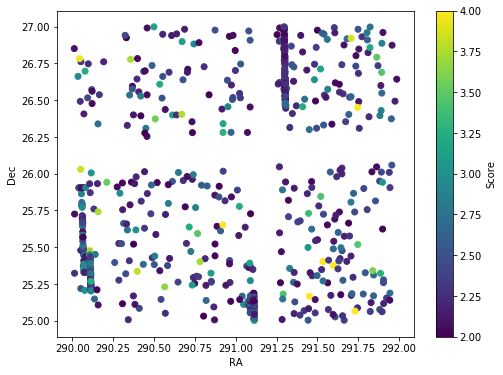

In [25]:
# Hmm, many of our dippers show up in a line on the sky!
ra = [i['ra'] for i in res]
dec = [i['dec'] for i in res]
xpos = [np.mean(i['xpos']) for i in res]

plt.figure(figsize=(8, 6))
plt.scatter(ra, dec, c = scores, vmin=2, vmax=4)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='Score')

(58338.0, 58338.5)

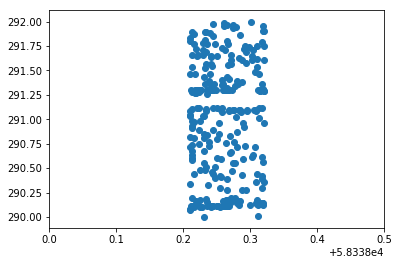

In [74]:
plt.scatter(mjds, ra)
plt.xlim(58338.0, 58338.5)

In [ ]:
3072 - 20

(58338.0, 58338.5)

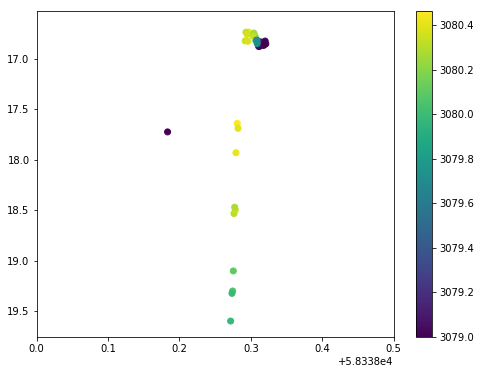

In [89]:
# Dips correspond to bad PSF fits
i = ordered_res[0]
plt.figure(figsize=(8, 6))
plt.scatter(i['mjd'], i['psfmag'], c=np.array(i['ypos']), vmin=3079)
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlim(58338.0, 58338.5)

In [103]:
np.min(all_x)

1.5379999876022339

In [83]:
1024*3

3072

In [90]:
all_x = []
all_y = []
for i in ordered_res:
    all_x.append(i['xpos'])
    all_y.append(i['ypos'])

In [96]:
all_x = np.hstack(all_x)
all_y = np.hstack(all_y)

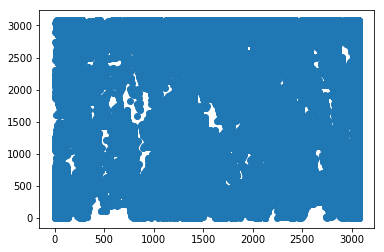

In [97]:
plt.figure()
plt.scatter(all_x, all_y)